# Import Library

In [ ]:
from google.colab import drive

import datetime
import calendar
import collections

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import seaborn as sns
import plotly.graph_objects as go

import networkx as nx
import community as community_louvain
from operator import itemgetter

import folium
from folium import plugins

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

# Read and Preprocessed CSV

In [ ]:
# https://drive.google.com/file/d/1XDW6IJcOulrAqOIHmol4gzqgA2AtS8Um/view?usp=share_link

# Need to wait approximately 2 minutes, because of the size

dataset_id = '1XDW6IJcOulrAqOIHmol4gzqgA2AtS8Um'

dataset_csv = f'https://drive.google.com/uc?id={dataset_id}&export=download&confirm=t'

df = pd.read_csv(dataset_csv)
df.head()

<ipython-input-76-a1e2006f5b60>:9: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_csv)


departure               return departure_id    departure_name  \
0  2020-03-23 06:09:44  2020-03-23 06:16:26           86          Kuusitie   
1  2020-03-23 06:11:58  2020-03-23 06:26:31           26        Kamppi (M)   
2  2020-03-23 06:16:29  2020-03-23 06:24:23          268  Porolahden koulu   
3  2020-03-23 06:33:53  2020-03-23 07:14:03          751        Vallipolku   
4  2020-03-23 06:36:09  2020-03-23 07:04:10           62  Länsisatamankatu   

  return_id       return_name  distance (m)  duration (sec.)  \
0     111.0     Esterinportti        1747.0            401.0   
1      10.0       Kasarmitori        1447.0            869.0   
2     254.0       Agnetankuja        1772.0            469.0   
3     106.0   Korppaanmäentie        7456.0           2406.0   
4     121.0  Vilhonvuorenkatu        7120.0           1679.0   

   avg_speed (km/h)  departure_latitude  departure_longitude  return_latitude  \
0          0.261397           60.195245            24.901900        60.197572   
1          0.099908           60.168610            24.930537        60.165017   
2          0.226695           60.195540            25.053581        60.187234   
3          0.185935           60.227827            24.819614        60.203474   
4          0.254437           60.158928            24.909692        60.186463   

   return_longitude  Air temperature (degC)  
0         24.926781                     0.9  
1         24.949473                     0.9  
2         25.036412                     0.9  
3         24.898930                     0.9  
4         24.967872                     0.9

In [ ]:
len(df)

12157458

In [ ]:
# Convert the 'date_column' from object to datetime
df['departure'] = pd.to_datetime(df['departure'])
df['return'] = pd.to_datetime(df['return'])

In [ ]:
df.columns

Index(['departure', 'return', 'departure_id', 'departure_name', 'return_id',
       'return_name', 'distance (m)', 'duration (sec.)', 'avg_speed (km/h)',
       'departure_latitude', 'departure_longitude', 'return_latitude',
       'return_longitude', 'Air temperature (degC)'],
      dtype='object')

In [ ]:
# Rename the 'old_column_name' to 'new_column_name'
df.rename(columns={'distance (m)': 'distance'}, inplace=True)
df.rename(columns={'duration (sec.)': 'duration'}, inplace=True)
df.rename(columns={'avg_speed (km/h)': 'avg_speed'}, inplace=True)
df.rename(columns={'Air temperature (degC)': 'Air temperature'}, inplace=True)

In [ ]:
df.dtypes

departure              datetime64[ns]
return                 datetime64[ns]
departure_id                   object
departure_name                 object
return_id                      object
return_name                    object
distance                      float64
duration                      float64
avg_speed                     float64
departure_latitude            float64
departure_longitude           float64
return_latitude               float64
return_longitude              float64
Air temperature               float64
dtype: object

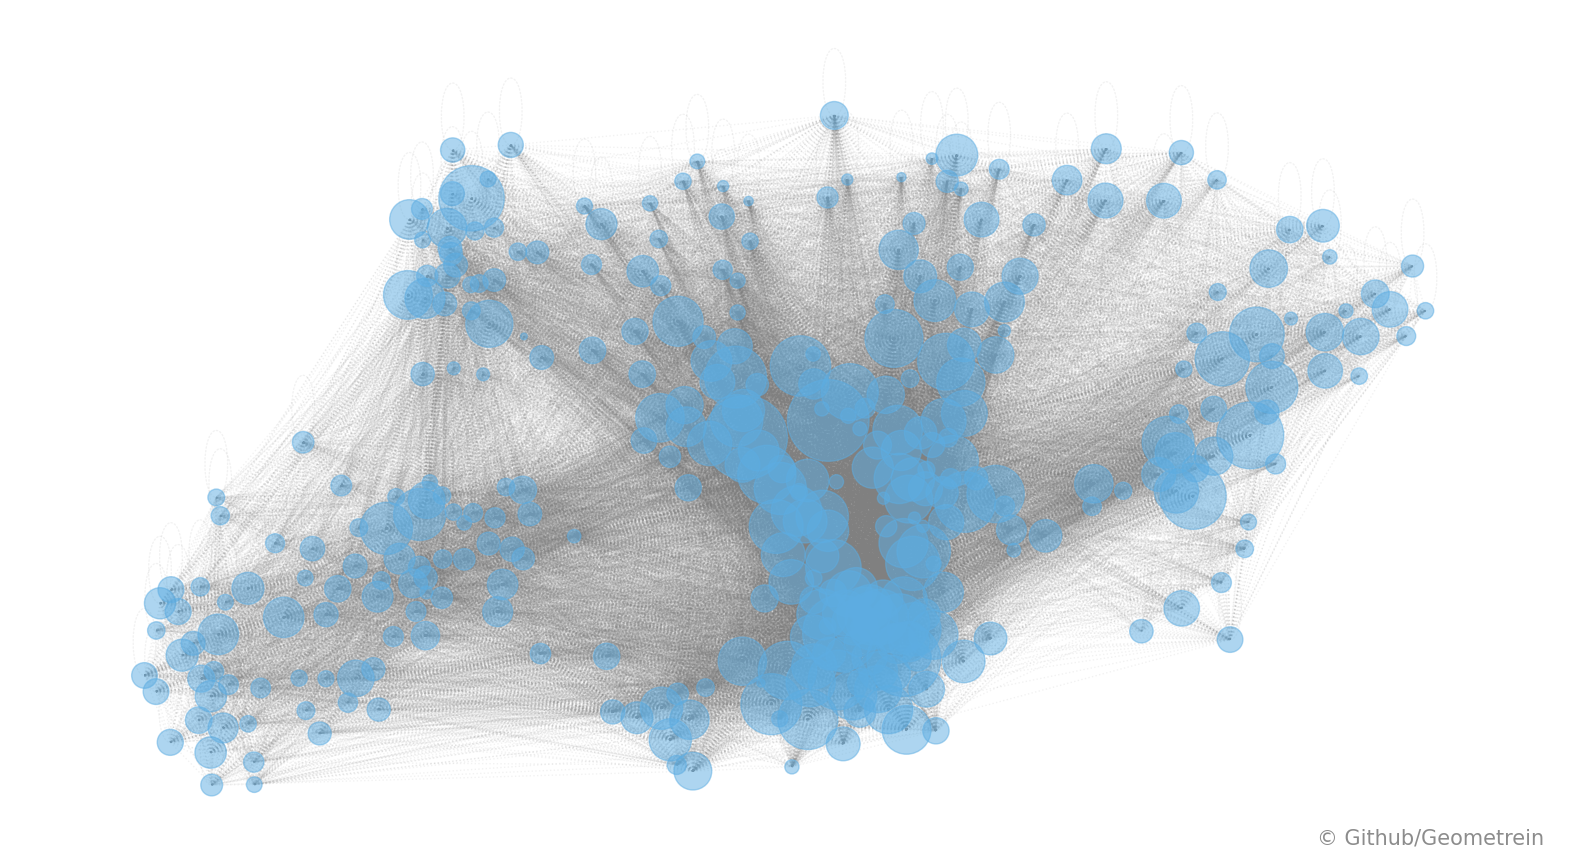

In [ ]:
def bikeNetwork(dataframe, year=2020):
  """
  This function plots the City bike network with node sizes illustrating station popularity.
  """
  # Data
  df = dataframe.copy()
  df = df[df['departure'].dt.year == year]
  # Drop NAN Value
  df.dropna(inplace=True)
  #print(df.isna().sum())

  # Graphs
  G = nx.Graph()
  G = nx.from_pandas_edgelist(df, 'departure_name', 'return_name', edge_attr=['duration','distance'])

  # Figure
  fig, ax = plt.subplots(figsize=(20,11))

  # Positions
  stantions  = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv")
  stantions.set_index('name',inplace=True)
  stantions["pos"] = list(zip(stantions["longitude"].astype(float), stantions["latitude"].astype(float)))
  pos = stantions.to_dict()['pos']

  # Map "pos" atribute to nodes from pos dict
  for node, position in pos.items():
      try:
          G.nodes[node]['pos'] = position
      except KeyError:
          pass

  # Draw
  nx.draw_networkx_nodes(G=G,pos=G.nodes.data('pos'), node_color=BLUE, alpha=0.5, node_size= (df['departure_name'].value_counts()/15).tolist())
  nx.draw_networkx_edges(G=G,pos=G.nodes.data('pos'), edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
  ax.axis('off')

  # Watermark
  ax.text(0.99, 0.01, '© Github/Geometrein',
          verticalalignment='bottom',
          horizontalalignment='right',
          transform=ax.transAxes,
          color='grey',
          fontsize=15,
          alpha = 0.9)

  return G

G = bikeNetwork(df)

In [ ]:
def networkStats(G, top_n):
  """
  This function prints the basic properties of the City bike network.
  """
  print(G)
  print('Number of nodes', len(G.nodes))
  print('Number of edges', len(G.edges))
  print('Average degree', sum(dict(G.degree).values()) / len(G.nodes))
  density = nx.density(G)
  print("Network density:", density)
  triadic_closure = nx.transitivity(G)
  print("Triadic closure:", triadic_closure)

  degree_dict = dict(G.degree(G.nodes()))
  nx.set_node_attributes(G, degree_dict, 'degree')
  #print(G.nodes['Kamppi (M)'])

  sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
  print("\nTop "+str(top_n)+" nodes (stations) by degree:\n")
  for d in sorted_degree[:top_n]:
      print(d)

  betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
  eigenvector_dict = nx.eigenvector_centrality(G) # Compute eigenvector centrality

  sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)

  print("\nTop "+str(top_n)+" nodes (stations) by betweenness centrality:\n")
  for b in sorted_betweenness[:top_n]:
      print(b)

user_input = 12
# Use the input function to get an integer from the user, un-comment the following lines to change the number
# user_input = input("Please enter top_n to be display: ")
integer_value = int(user_input)
networkStats(G, integer_value)

Graph with 347 nodes and 31784 edges
Number of nodes 347
Number of edges 31784
Average degree 183.19308357348703
Network density: 0.5294597791141243
Triadic closure: 0.7366335805953699

Top 12 nodes (stations) by degree:

('Haukilahdenkatu', 317)
('Paciuksenkaari', 285)
('Laajalahden aukio', 281)
('Itämerentori', 280)
('Huopalahdentie', 280)
('Munkkiniemen aukio', 273)
('Ympyrätalo', 272)
('Töölöntulli', 270)
('Tilkanvierto', 268)
('Paciuksenkatu', 266)
('Pasilan asema', 266)
('Esterinportti', 263)

Top 12 nodes (stations) by betweenness centrality:

('Haukilahdenkatu', 0.016237342450916282)
('Itämerentori', 0.005948449497953777)
('Paciuksenkaari', 0.00492626443333381)
('Laajalahden aukio', 0.0048554542068282415)
('Huopalahdentie', 0.004507019469877409)
('Lauttasaaren ostoskeskus', 0.004488203624779069)
('Lehtisaarentie', 0.004241566875420245)
('Jämeräntaival', 0.0042220602778844625)
('Munkkiniemen aukio', 0.0041552798152275205)
('Aalto-yliopisto (M), Korkeakouluaukio', 0.0040461090524

In [ ]:
def mapPlot(dataframe, year = 2020):
  """
  This function prints an interactive bubble plot by destination locations for a given year.
  """
  # Data
  df = dataframe.copy()
  df = df[df['departure'].dt.year == year]
  #df = df[:1000]
  df.dropna(inplace=True)
  df['freq'] = df.groupby('departure_name')['departure_name'].transform('count')
  #print(df.isna().sum())
  df["name"] = df["departure_name"]
  df = df[["name", "freq"]]
  df = df.drop_duplicates(subset=['name'])
  freq_dict = dict(zip(df.name, df.freq))

  df_stations = pd.read_csv("https://raw.githubusercontent.com/Geometrein/helsinki-city-bikes/main/data/downloaded_data/station_coordinates.csv", index_col=False)
  df_stations = df_stations[df_stations["latitude"]<=60.254011]
  #print(df_stations.head())
  df_stations['freq']= df_stations['name'].map(freq_dict)
  #print(df_stations.head(), df_stations.isna().sum(), len(df_stations))
  df_stations["freq_adj"] = df_stations['freq']/(df_stations['freq'].median()/3)
  df_stations.fillna(1, inplace=True)
  df_stations.dropna(inplace=True)

  # Map
  hel_map = folium.Map([60.1975594, 24.9320720], zoom_start=12)
  folium.TileLayer('cartodbdark_matter').add_to(hel_map)

  for index, row in df_stations.iterrows():
      folium.CircleMarker([row['latitude'],row['longitude']],
                      radius=row["freq_adj"],
                      popup=row['freq'],
                      color="#eab544",
                      fill_color="#eab544",
                  ).add_to(hel_map)

  display(hel_map)

# function call is commented for performance reasons
mapPlot(df)

<ipython-input-85-5e5f3ae08d40>:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


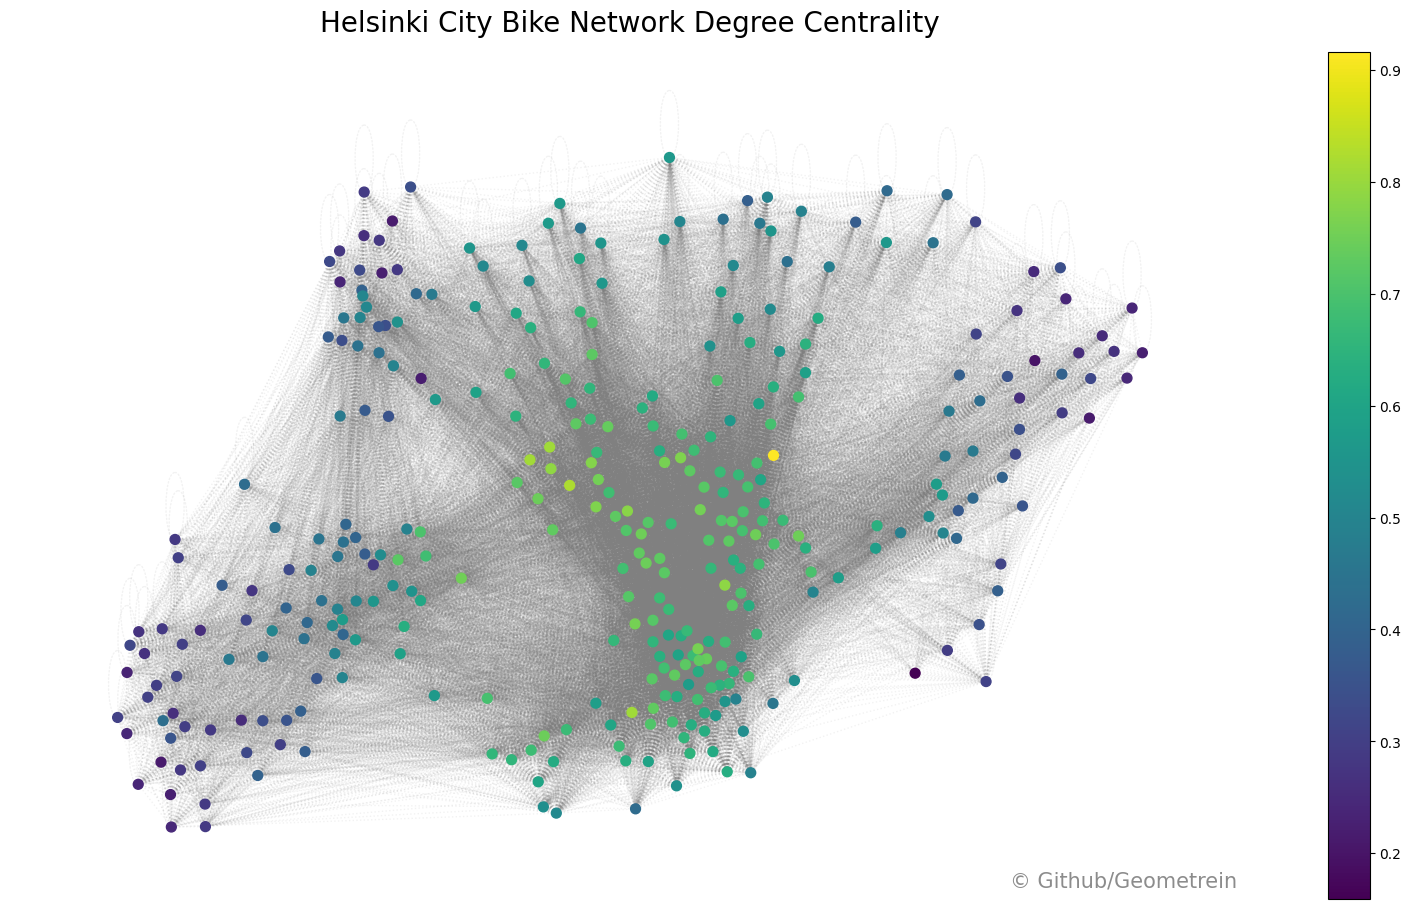

In [ ]:
def centralityDegree(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Helsinki City Bike Network Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)


# function call is commented for performance reasons
centralityDegree(G)

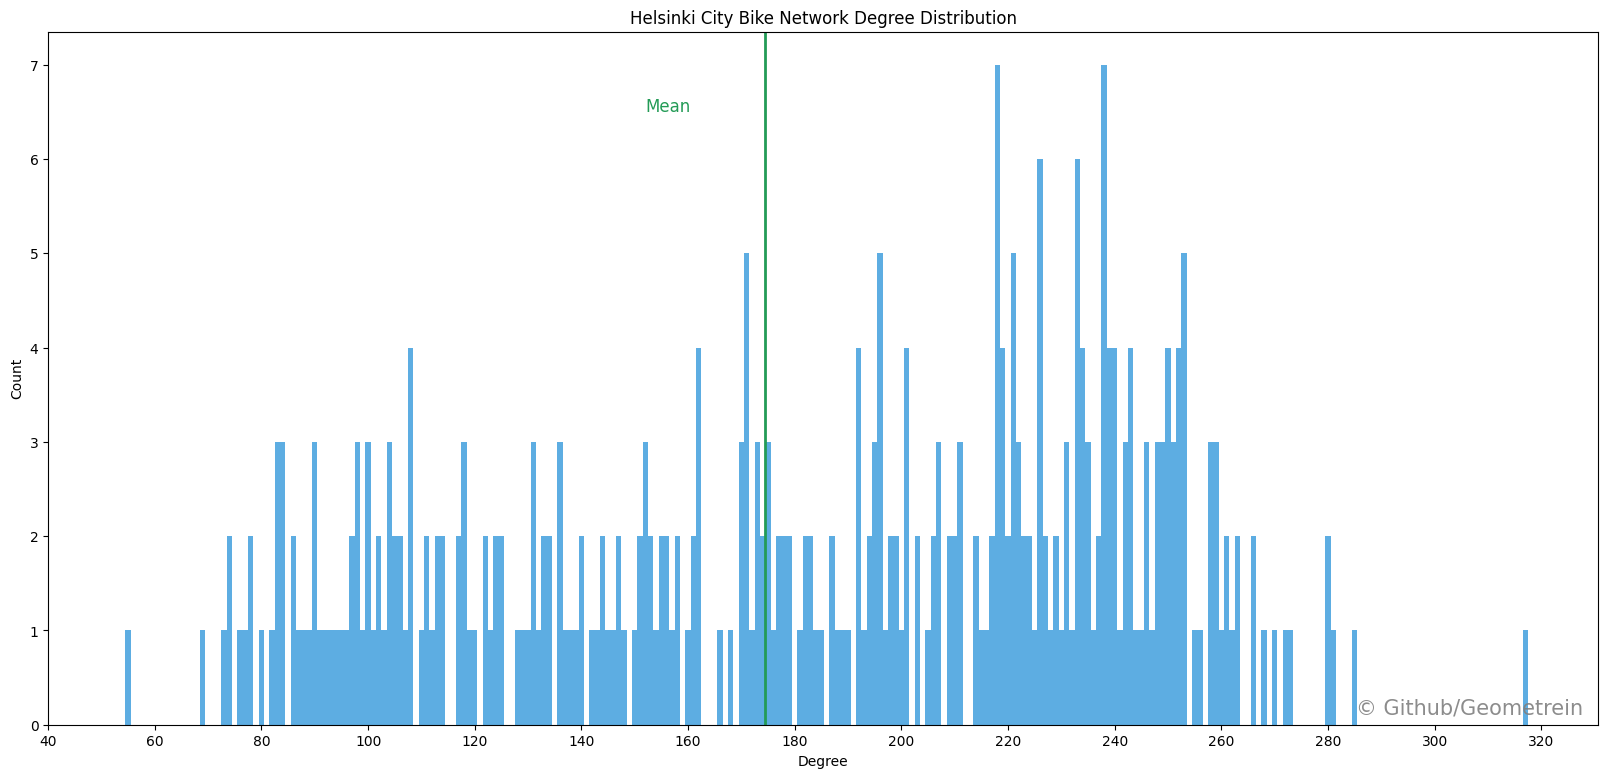

In [ ]:
def centralityDegreeDist(G):
    """
    Centrality degree distribution
    """
    # Degree
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    # Figure
    fig, ax = plt.subplots(figsize=(20,9))
    plt.bar(deg, cnt, width=1, color=BLUE)
    plt.axvline(x = sum(deg)/len(deg), color=GREEN, linestyle='-', linewidth=2) # Degree Mean
    #plt.axvline(x = np.median(deg), color="blue", linestyle='-', linewidth=1) # Degree Median

    # Labeling
    plt.title("Helsinki City Bike Network Degree Distribution")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    plt.text(x= 152,y=6.5, s="Mean", color = GREEN, fontsize= 12)
    ax.set_xticks(range(40,340,20))

    # Watermark
    ax.text(0.99, 0.01, '© Github/Geometrein',
            verticalalignment='bottom',
            horizontalalignment='right',
            transform=ax.transAxes,
            color='grey',
            fontsize=15,
            alpha = 0.9)

    plt.show()

centralityDegreeDist(G)

In [ ]:
nx.diameter(G)

3

In [ ]:
nx.average_shortest_path_length(G)

1.4768702836867618

In [ ]:
nx.density(G)

0.5294597791141243

In [ ]:
between =  nx.betweenness_centrality(G)
between

{'Kuusitie': 0.0029838221211908,
 'Esterinportti': 0.003103599764741989,
 'Kamppi (M)': 0.003049208536307055,
 'Kasarmitori': 0.0004572065059086275,
 'Porolahden koulu': 0.0004138742604774926,
 'Agnetankuja': 0.00047635045064974805,
 'Vallipolku': 0.0003362735733277239,
 'Korppaanmäentie': 0.0015002588848596484,
 'Länsisatamankatu': 0.002718669082398271,
 'Vilhonvuorenkatu': 0.0025617325706784756,
 'Radiokatu': 0.0010963559484720763,
 'Porthania': 0.0023155253231931803,
 'Tyynenmerenkatu': 0.001204555703398055,
 'Hietalahdentori': 0.002358949193316381,
 'Itämerentori': 0.005948449497953777,
 'Meilahden sairaala': 0.00246695306435274,
 'Koskelantie': 0.001970880238781594,
 'Kalasatama (M)': 0.0037544561330927176,
 'Rautatieläisenkatu': 0.0017185842638379745,
 'A.I. Virtasen aukio': 0.0007444381816000155,
 'Töölönkatu': 0.0016001601355046427,
 'Rautatientori / itä': 0.00335833222010957,
 'Roihupelto': 0.00034659840791769977,
 'Siilitie (M)': 0.0005490500843436122,
 'Hakaniemi (M)': 0.002

In [ ]:
#create two simple graphs from our original directed graph
G_simple = nx.Graph(G)
G_simple2 = nx.Graph(G)


nx.node_connectivity(G_simple)

53

In [ ]:
#taken from. https://github.com/gboeing/osmnx
def great_circle_vec(lat1, lng1, lat2, lng2, earth_radius=6371009):

    phi1 = np.deg2rad(90 - lat1)

    phi2 = np.deg2rad(90 - lat2)

    theta1 = np.deg2rad(lng1)
    theta2 = np.deg2rad(lng2)

    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) + np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(cos)

    distance = arc * earth_radius

    return distance


def get_nearest_node(G, point):

    coords = np.array([[data[0], data[1][0], data[1][1]] for data in G.nodes.data('pos')])
    df = pd.DataFrame(coords, columns=['node', 'x', 'y']).set_index('node')
    df['reference_y'] = point[0]
    df['reference_x'] = point[1]

    distances = great_circle_vec(lat1=df['reference_y'],
                                 lng1=df['reference_x'],
                                 lat2=df['x'].astype('float'),
                                 lng2=df['y'].astype('float'))

    # nearest_node = int(distances.idxmin())
    # print(distances.idxmin())
    nearest_node = distances.idxmin()

    return nearest_node

Kuusitie
Agnetankuja
Shortest Path:
['Kuusitie', 'Porolahden koulu', 'Agnetankuja']
Betweenness Centrality for each node on the path
[0.0029838221211908, 0.0004138742604774926, 0.00047635045064974805]


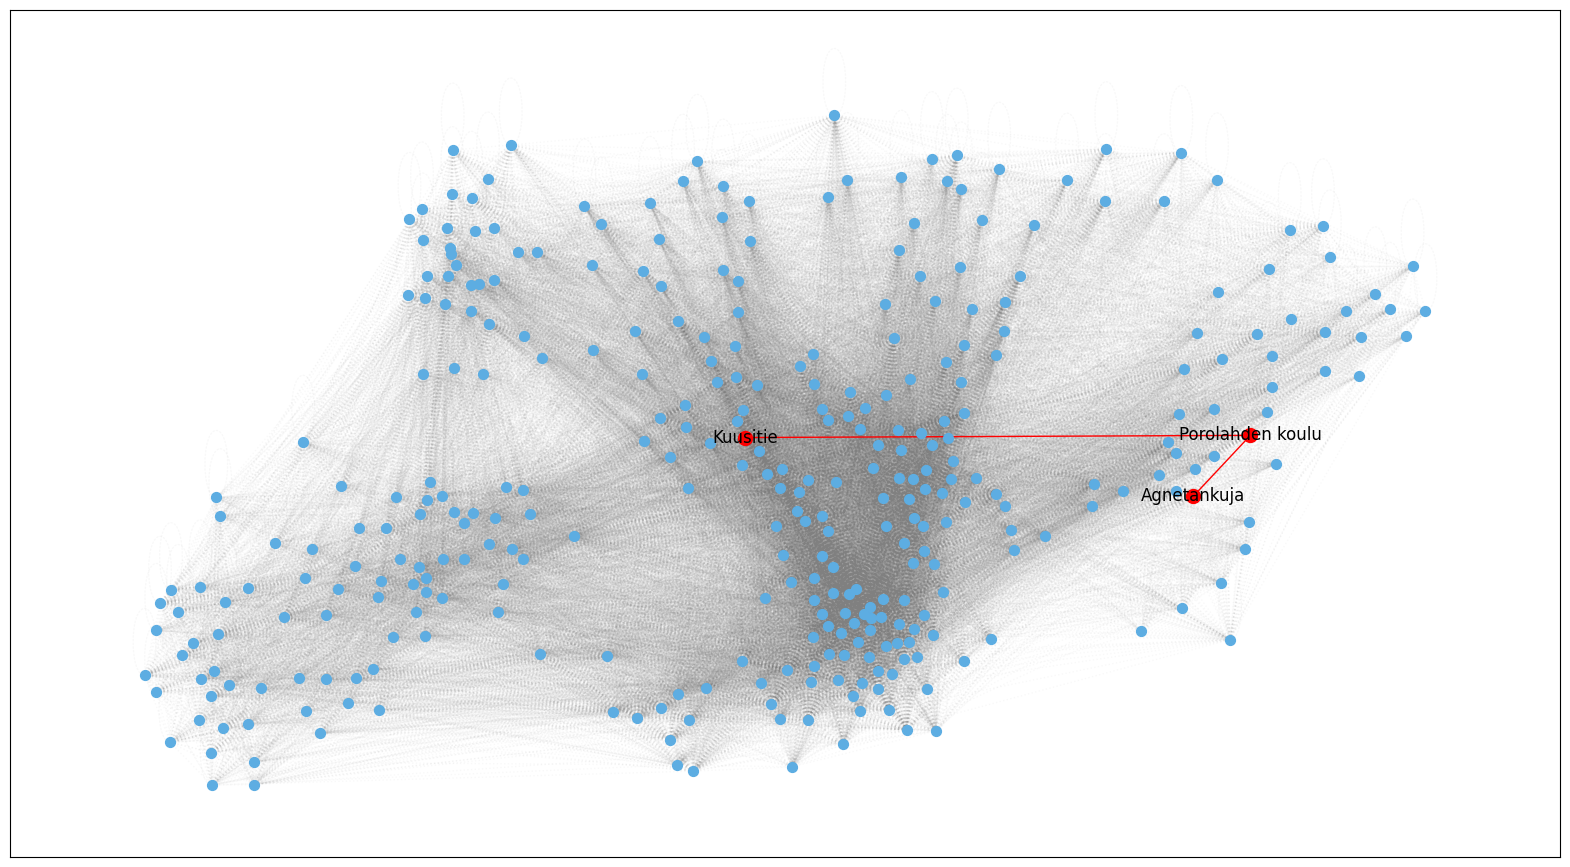

In [ ]:
pick_point = ( df['departure_longitude'][0],df['departure_latitude'][0])
drop_point = ( df['return_longitude'][2],df['return_latitude'][2])

pick_node = get_nearest_node(G, pick_point)
drop_node = get_nearest_node(G, drop_point)

print(pick_node)
print(drop_node)

try:
  route = nx.shortest_path(G, str(pick_node), str(drop_node))
  print("Shortest Path:")
  print(route)
except:
  print("Some Error")
  #handle error
  pass

# Create a subgraph for the shortest path
H = G.subgraph(route)

# Initiation graph
fig, ax = plt.subplots(figsize=(20,11))

# Draw
nx.draw_networkx_nodes(G=G, pos=G.nodes.data('pos') ,node_color=BLUE, alpha=1, node_size= 50)
nx.draw_networkx_nodes(G=H, pos=H.nodes.data('pos') ,node_color='red', alpha=1, node_size= 100)
nx.draw_networkx_edges(G=G, pos=G.nodes.data('pos') ,edge_color='grey', style ="dotted", alpha=0.05, arrows=False)
nx.draw_networkx_edges(G=H, pos=H.nodes.data('pos') ,edge_color='red', style ="solid", alpha=1, arrows=False)
nx.draw_networkx_labels(G=H,pos=H.nodes.data('pos'))

#the corresponding node betweenness scores for each edge in the shortest path
print("Betweenness Centrality for each node on the path")
node_bet = []
for edge in route:
    node_bet.append(between[edge])
print(node_bet)